After running the FP-Growth notebook, rules notebook, and server assignment notebook, you should now have csvs with the modeled and origninal data.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
latency_time_80=pd.read_csv('latency_time_80.csv') #the total and average latency times after we ran the fp growth model at the 80th percentile support, and confidence=0.7
latency_time_40=pd.read_csv('latency_time_40.csv')

latency_matrix_40=pd.read_csv('latency_matrix_40_70con.csv')
latency_matrix_80=pd.read_csv('latency_matrix_80_70con.csv')

server_df40=pd.read_csv('df_servers40.csv') #this is the oringinal dataframe merged in with our server assignments, and modeled durations
server_df80=pd.read_csv('df_servers80.csv') #it is a huge file that cannot be uploaded to github, but was created in the server rules notebook
server_df40['Date']=pd.to_datetime(server_df40['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
server_df40['date_hr']=pd.Series(server_df40['Date']).dt.round("H")
server_df80['Date']=pd.to_datetime(server_df80['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
server_df80['date_hr']=pd.Series(server_df80['Date']).dt.round("H")

server_rules40=pd.read_csv('server_rules40.csv')
server_rules80=pd.read_csv('server_rules_80_70con.csv') #the server assignments for this FP model at 80 support and 70% confidence

In [ ]:
server_df40['Date']=pd.to_datetime(server_df40['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
server_df40['date_hr']=pd.Series(server_df40['Date']).dt.round("H")
server_df80['Date']=pd.to_datetime(server_df80['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
server_df80['date_hr']=pd.Series(server_df80['Date']).dt.round("H")


## 1. let's just see how the models did with total latency reduction

In [ ]:
latency_matrix=pd.concat([latency_matrix_40, latency_matrix_80])
latency_time=pd.concat([latency_time_40, latency_time_80])

In [ ]:
latency_time['percent_improvement']=None
latency_time['percent_improvement']=(latency_time['total_time'].max()-latency_time['total_time'])/latency_time['total_time'].max()*100
latency_time

Text(0,0.5,'Latency Improvement (%)')

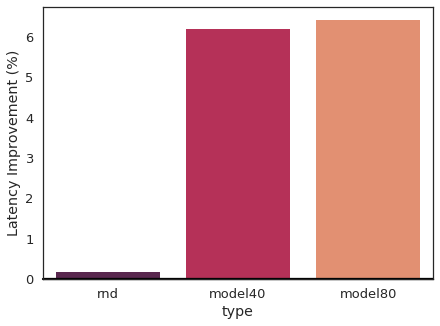

In [6]:
sns.set(style="white", context="talk")
rs = np.random.RandomState(8)

# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(7, 5), sharex=True)

sns.barplot(x=latency_time['type'][latency_time['type']!='orig'], y=latency_time['percent_improvement'][latency_time['type']!='orig'], palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Latency Improvement (%)")

The Random model, where we just assigned servers at random did improve overall latency reduction, around 0.001%, while the FP-Growth model at a min support (meaning these pairs occured this % in the dataset) at the 40th percentile, and 80th percentile did much better.

Interestingly, while you would expect the model with a lower min threshold, the model40 to do better because it is creating more rules than the model80, it actually did a little bit worse. This is likely because of all the extra servers you need to assign to capture these rules. For example, in the model40 you have ~300 IPs that have rules and need to be assigned to a server, this is 300/20apps per server = 15 servers. So, the chance that important apps can end up on the same server is greater than in the other scenario. In model80 there are ~1200 IPs that need server assignments, this translates to 1200/20 = 60 servers. Now, while we prioritize important apps to get on the same server, because of cross-talk (where 1 app talks to many others) it is now less likely that these repeater apps will end up on the same server. So, our ability to reduce latency actually decreases when we lower our threshold.

Text(0,0.5,'Total Latency (s)')

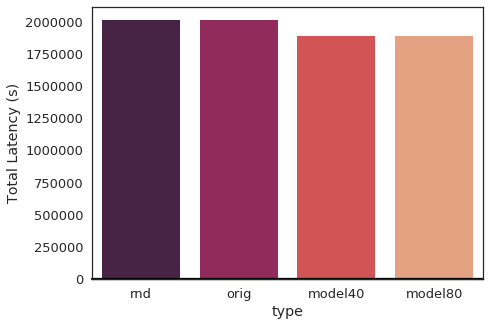

In [11]:
sns.set(style="white", context="talk")
rs = np.random.RandomState(8)

# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(7, 5), sharex=True)

sns.barplot(x=latency_time['type'], y=latency_time['total_time'], palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Total Latency (s)")

## 2. Can we still get a big improvement by only implementing some of these rules?

In [26]:
latency_matrix

,Unnamed: 0,latency_total,latency_avg,percent_rules,num_rules,model
0,0,1889864.341,0.230866,0.05,80,per40_70con
1,1,1889546.868,0.230827,0.25,420,per40_70con
2,2,1889540.067,0.230826,0.50,840,per40_70con
3,3,1889540.067,0.230826,0.75,1280,per40_70con
4,4,1889540.067,0.230826,1.00,1700,per40_70con
0,0,1886554.666,0.230461,0.05,20,per80_70con
1,1,1885068.874,0.230280,0.25,80,per80_70con
2,2,1884916.451,0.230261,0.50,160,per80_70con
3,3,1884878.507,0.230257,0.75,260,per80_70con
4,4,1884878.507,0.230257,1.00,340,per80_70con


In [48]:
lm=latency_matrix.groupby(['model', 'percent_rules', 'num_rules'])['latency_total'].sum()
lm=lm.groupby(level=0).apply(lambda x: 1- (x-x.min()) / x) #we want to know about how much latency are we gaining by implementing all the rules instead of a subset
lm.columns=['model', 'percent_rules', 'percent_latency_achieved']

In [49]:
lm

model        percent_rules  num_rules
per40_70con  0.05           80           0.999828
             0.25           420          0.999996
             0.50           840          1.000000
             0.75           1280         1.000000
             1.00           1700         1.000000
per80_70con  0.05           20           0.999112
             0.25           80           0.999899
             0.50           160          0.999980
             0.75           260          1.000000
             1.00           340          1.000000
Name: latency_total, dtype: float64

In [ ]:
hour_duration_groups=server_df40.groupby(['date_hr']).agg({'Duration':['sum','mean'],      # find the sum of the durations for each group
                                     'duration_pred': ['sum', 'mean']},
                                            '') 

hour_duration_groups.columns=['duration_sum', 'duration_mean', 'duration_pred_sum', 'duration_pred_mean']
hour_duration_groups['date_hr']=hour_duration_groups.index
hour_duration_groups['latency_change']=hour_duration_groups['duration_sum']-hour_duration_groups['duration_pred_sum'] #subtract the original time with our modeled time

If we think outliers are having a big impact, if we remove the durations above the 95% percentile, how does this change our analysis?

In [ ]:
duration95

### 3. How does latency change with time?

In [ ]:
#Let's make an hour timestep and see how total latency varies over time

from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()
ax.plot(hour_duration_groups['date_hr'], hour_duration_groups['duration_sum'])
ax.plot(hour_duration_groups['date_hr'], hour_duration_groups['duration_pred_sum'])

myFmt = DateFormatter("%m-%d")
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)
ax.annotate('Weekend', xy=('2017-8-6', 100), xytext=('2017-8-6', 500),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Total latency (s)')
plt.xlabel('month-day')
plt.title('Total latency')
plt.show()

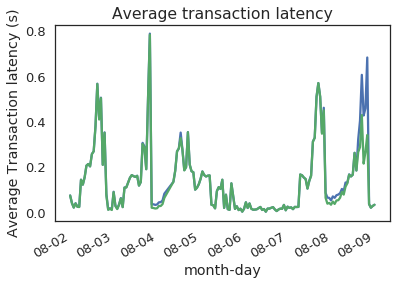

In [41]:
#plot the average latency each hour block
fig, ax = plt.subplots()
ax.plot(hour_duration_groups['date_hr'],hour_duration_groups['duration_mean'])
ax.plot(hour_duration_groups['date_hr'],hour_duration_groups['duration_pred_mean'])

myFmt = DateFormatter("%m-%d")
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)
#ax.annotate('Weekend', xy=('2017-8-6', 100), xytext=('2017-8-6', 500),
          #  arrowprops=dict(facecolor='black', shrink=0.05),
           # )

## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Average Transaction latency (s)')
plt.xlabel('month-day')
plt.title('Average transaction latency') #calculated on a hour timestep
plt.show()

In [9]:
server_df40.head()

,Unnamed: 0,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2,Src_Server,Dst_Server,duration_pred,rnd_src_server,rnd_dst_server,duration_rnd
0,0,2017-08-02 00:00:00.419,0.003,192.168.210.55,44870,192.168.100.11,445.0,2,174,2017-08-02,"['192.168.100.11', '192.168.210.55']","('192.168.100.11', '192.168.210.55')",1.0,NaN,0.003,18.0,NaN,0.003
1,1,2017-08-02 00:00:00.421,0.000,192.168.100.11,445,192.168.210.55,44870.0,1,108,2017-08-02,"['192.168.100.11', '192.168.210.55']","('192.168.100.11', '192.168.210.55')",NaN,1.0,0.000,NaN,NaN,0.000
2,2,2017-08-02 00:00:02.593,0.004,192.168.220.47,55101,192.168.100.11,445.0,2,174,2017-08-02,"['192.168.100.11', '192.168.220.47']","('192.168.100.11', '192.168.220.47')",0.0,NaN,0.004,79.0,NaN,0.004
3,3,2017-08-02 00:00:02.859,0.000,10000_34,443,192.168.210.54,59628.0,1,100,2017-08-02,"['10000_34', '192.168.210.54']","('10000_34', '192.168.210.54')",NaN,0.0,0.000,3.0,NaN,0.000
4,4,2017-08-02 00:00:02.594,0.000,192.168.100.11,445,192.168.220.47,55101.0,1,108,2017-08-02,"['192.168.100.11', '192.168.220.47']","('192.168.100.11', '192.168.220.47')",NaN,0.0,0.000,NaN,NaN,0.000


Why are we getting so much benefit at the last day?? Are there less IPs being used in this timespan?


In [34]:
#Number of unique pairs occuring in each hour timestep

pairs_hour=server_df40.groupby(['date_hr'])['pairs2'].nunique()
pairs_hour=pairs_hour.reset_index()
pairs_hour.columns=['date_hr', 'unique_pairs']


In [45]:
pairs_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 2 columns):
date_hr         165 non-null datetime64[ns]
unique_pairs    165 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.7 KB


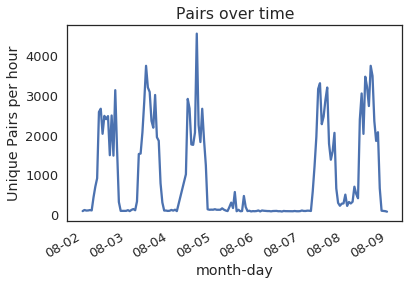

In [46]:
fig, ax = plt.subplots()
ax.plot(pairs_hour['date_hr'] ,pairs_hour['unique_pairs'])

myFmt = DateFormatter("%m-%d")
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Unique Pairs per hour')
plt.xlabel('month-day')
plt.title("Pairs over time")
plt.show()

Number of transactions, or requests, over time

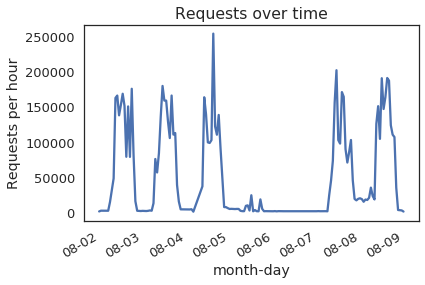

In [49]:
requests_hour=server_df40.groupby(['date_hr'])['Date'].count()
requests_hour=requests_hour.reset_index()
requests_hour.columns=['date_hr', 'requests']


fig, ax = plt.subplots()
ax.plot(requests_hour['date_hr'] ,requests_hour['requests'])

myFmt = DateFormatter("%m-%d")
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Requests per hour')
plt.xlabel('month-day')
plt.title("Requests over time")
plt.show()

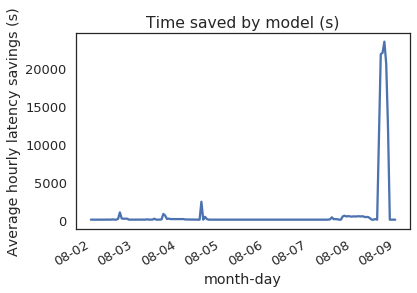

In [54]:
#average latency in each hour time saved from model
fig, ax = plt.subplots()
ax.plot(hour_duration_groups['date_hr'],hour_duration_groups['latency_change'])

myFmt = DateFormatter("%m-%d")
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Average hourly latency savings (s)')
plt.xlabel('month-day')
plt.title("Time saved by model (s)")
plt.show()


Did the number of unique pairs change in this last day? or is it somehow easier to assign the correct server to these IPs?

4. How much money do we save?

Simply tally the total bytes transferred, and reduce this value by the % reduction in latency achieved with our model. Then apply a cost per byte fo determine our savings.

Bandwidth is charged on a pay-as-you-go basis, and it is calculated on the actual bandwidth usage (GB) in your last month multiplied by AWS bandwidth charges ($0.12 / GB). For example, if your server consumed 100GB bandwidth in the month, you will be charged for $12 (100GB x $0.12).

In [ ]:
bytes_orig=server_df40['Bytes'].sum()

In [ ]:
server_df40.info()

In [ ]:
bytes_model40=bytes_orig*(1-latency_time['percent_improvement'][latency_time['type']=='model40'])